s216169, Magnus Bengtsson

s194268, Anton Jørgensen

Group 12

# Exercise 1

## In this exercise you should implement everything including the tests (e.g. the chi-square and KS tests) yourself. Later, when your code is working you are free to use builtin functions.

## 1. Write a program implementing a linear congruential generator (LCG). Be sure that the program works correctly using only integer representation

### (a) Generate 10.000 (pseudo-) random numbers and present these numbers in a histogramme (e.g. 10 classes).

We write a LCG that can only take integer values. It is defined by:
$$
X_{n+1} = (aX_n+c)\mod M
$$
Here, $a$ is the multiplier, $c$ is the shift, and $M$ is the modulus. 

We initialize the algorithm by setting $X_0 = 2^{30} - 1$, the multiplier $a=48271$, the shift $c=0$, and the modulus $M=2^{31} - 1$. 

Thus, we can generate 10000 pesuodo-random numbers.

In [48]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy.stats import chisquare, kstest, chi2, norm, pearsonr
from statsmodels.sandbox.stats.runs import runstest_1samp
from math import sqrt, exp
np.random.seed(1234)

def linear_congruential(x0, multiplier, shift, modulus, n=10000, to_unit_interval=True):
    xs = np.empty(n + 1)
    xs[0] = x0
    for i in range(1, n + 1):
        xs[i] = (multiplier * xs[i - 1] + shift) % modulus

    if to_unit_interval:
        return xs[1:] / modulus
    return xs[1:]

values = linear_congruential(2**30 - 1, 48271, 0, 2 ** 31 - 1)
values

array([0.49998876, 0.95748378, 0.6993237 , ..., 0.90753563, 0.65215983,
       0.40703805], shape=(10000,))

We construct a histogram and a scatterplot of the values. This helps reveal any potential patterns or correlations between consecutive numbers, which would indicate poor randomness.

This shows a reasonably uniform spread of points across the unit square, albeit definitely some reoccurence, i.e., a short cycle.

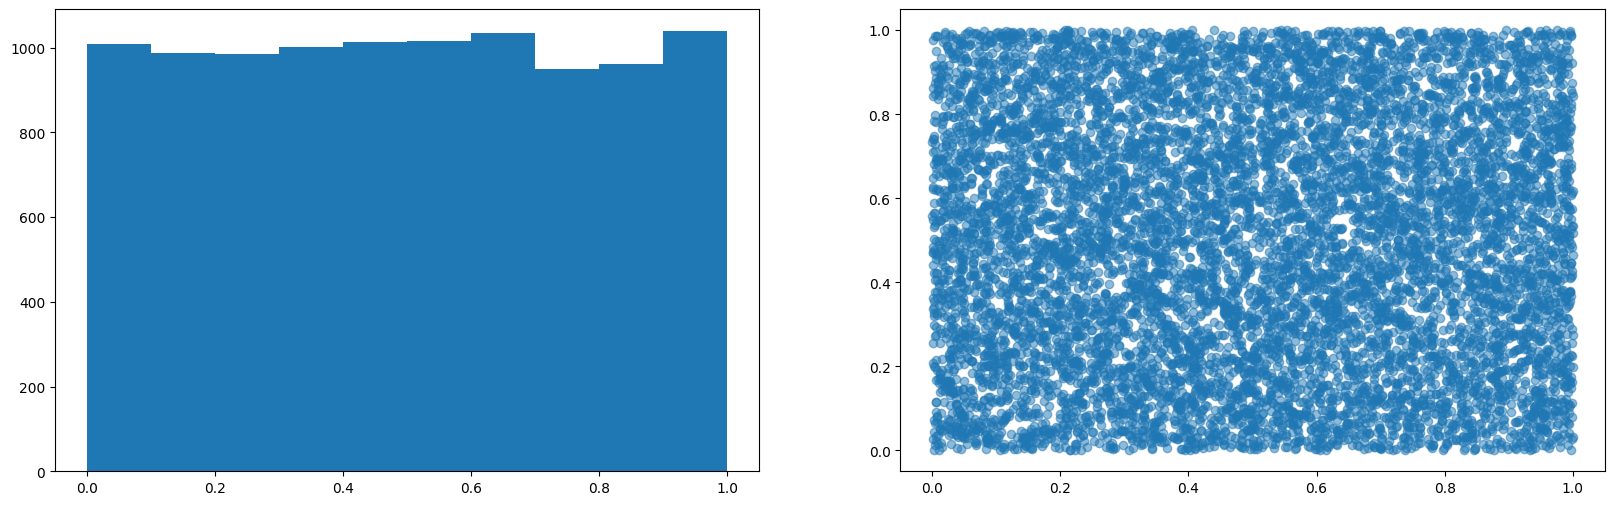

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.hist(values)
ax2.scatter(values[:-1], values[1:], alpha=0.5)

On the left, the histogram shows a fairly uniform distribution, suggesting the LCG is producing values that are evenly spread out, on the interval $[0,1)$. The scatterplot on the right displays a seemingly uniform cloud of points across the plot, suggesting a weak serial correlation. If there was a strong visible pattern, it would suggest a deterministic structure and thus, poor randomness. So initially, this seems promising for LCG.

### (b) Evaluate the quality of the generator by descriptive statistics (histogrammes, scatter plots) and statistical tests - χ2, Kolmogorov-Smirnov, run-tests, andcorrelation test.

To assess whether the values generated by the LCG are uniformly distributed, a chi-square goodness-of-fit test is done. Here, 10 classes is used, meaning the degrees of freedom is 9.

In [50]:
num_bins = 10
observed_counts, _ = np.histogram(values, bins=num_bins)
expected_count = len(values) / num_bins
expected_counts = np.full(num_bins, expected_count)

T = sum((obs-exp)**2 / exp for obs, exp in zip(observed_counts, expected_counts))
df = 9
p_value = 1 - chi2.cdf(T, df)
print(f"Chi-square T = {T:.2f}, p-value = {p_value:.2f}")

Chi-square T = 7.58, p-value = 0.58


Here, we see the p-value of 0.58 is obtained, meaning the null hypothesis cannot be discarded of an uniform distribution. Thus, the numbers from the LFG generated do suggest to follow an Uniform distribution.

To further evaluate the uniformity of the numbers, the Kolmogorov-Smirnov test is also applied. We follow the methods descriped as in Numerisk Simulation, Chapter 3, by Iversen, and Simulation, Chapter 11, by Ross:

In [51]:
sorted_values = np.sort(values) #First sort
n = len(values)

D_plus = np.max([(i + 1)/n - x for i, x in enumerate(sorted_values)])
D_minus = np.max([x - i/n for i, x in enumerate(sorted_values)])
D_statistic = max(D_plus, D_minus)

lambda_val = (sqrt(n) + 0.12 + 0.11/sqrt(n)) * D_statistic
p_value = 2 * sum((-1)**(k-1) * exp(-2 * k**2 * lambda_val**2) for k in range(1, 100))

print(f"KS statistic = {D_statistic:.2f}, p-value = {p_value:.2f}")

KS statistic = 0.01, p-value = 0.84


Since the p-value is 0.84, we again cannot reject the null hypothesis. Thus, there is no evidence against uniformity, supporting the idea of the LCG performing well in terms of uniformity.

Now, a Wald–Wolfowitz run test is done, which assesses randomness based on the median. It suggests if the sequence of values generated by the LCG has an abnormal amount of runs, suggesting if there is or is not randomness in the number sequence, as described by Simulation, Chapter 11, by Ross:

In [52]:
median = np.median(values)
binary_seq = np.where(values > median, 1, 0)

runs = 1
for i in range(1, len(binary_seq)):
    if binary_seq[i] != binary_seq[i - 1]:
        runs += 1

n1 = np.sum(binary_seq)
n0 = len(binary_seq) - n1

mu = 2 * n1 * n0 / (n1 + n0) + 1
var = (2 * n1 * n0 * (2 * n1 * n0 - n1 - n0)) / (((n1 + n0) ** 2) * (n1 + n0 - 1))

z = (runs - mu) / sqrt(var)
p_value = 2 * (1 - norm.cdf(abs(z)))

print(f"Run test (Wald–Wolfowitz) score: z = {z:.2f}, p-value = {p_value:.2f}")

Run test (Wald–Wolfowitz) score: z = -0.60, p-value = 0.55


Again, we fail to discard the null hypothesis, meaning there is no statistical evidence to suggest the process is non-random. Thus, the number of runs is consistent with what we would expect from a random binary sequence, supporting the idea the generated values exhibit randomness relative to the median.

To check whether the generated values are independent of each other, we calculate the lag-1 to lag-10 correlatiosn- the correlation between $U[i]$ and $U[i+1]$ to $U[i+10]$:

We can print the first 10 lags:

Lag-1 correlation = -0.0030, p-value = 0.7608
Lag-2 correlation = 0.0097, p-value = 0.3343
Lag-3 correlation = -0.0053, p-value = 0.5979
Lag-4 correlation = -0.0036, p-value = 0.7157
Lag-5 correlation = -0.0017, p-value = 0.8645
Lag-6 correlation = 0.0088, p-value = 0.3796
Lag-7 correlation = 0.0191, p-value = 0.0563
Lag-8 correlation = -0.0009, p-value = 0.9271
Lag-9 correlation = 0.0011, p-value = 0.9112
Lag-10 correlation = 0.0037, p-value = 0.7102


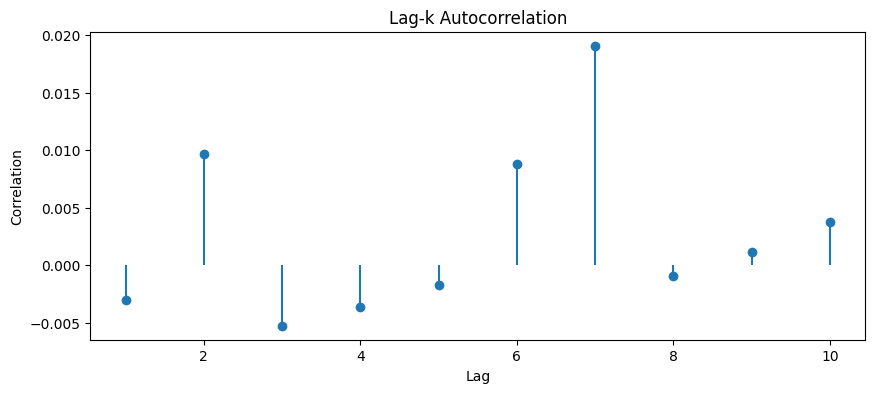

In [53]:
max_lag = 10
correlations = []
p_values = []

for lag in range(1, max_lag + 1):
    u1 = values[:-lag]
    u2 = values[lag:]
    corr, p_val = pearsonr(u1, u2)
    correlations.append(corr)
    p_values.append(p_val)
    print(f"Lag-{lag} correlation = {corr:.4f}, p-value = {p_val:.4f}")

# Optionally plot
plt.figure(figsize=(10, 4))
plt.stem(range(1, max_lag+1), correlations, basefmt=" ")
plt.title("Lag-k Autocorrelation")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

As the first 10 lags show minimal correlation, they suggest almost none of a correlation between units. Furthermore, every lag has a high p-value, meaning we can reject the null hypotheseis - thus, we do not have sufficient evidence of the values being dependent.

Therefore, we would with some decent certainty deem our LCG for generating random, uniform-distributed numbers.

### (c) Repeat (a) and (b) by experimenting with different values of “a”, “b” and “M”. In the end you should have a decent generator. Report at least one bad and your final choice.

To identify a good combination of parameters $a$, $b$, and $M$ for the LCG, multiple configurations are now evaluated, testing them for uniformity and randomness. 

Here, a despicable choice is presented, where $X_0 = 7$, $a=6$, $c=0$, $M=11$:

In [54]:
test1 = linear_congruential(7, 6, 0, 11)
test1

array([0.81818182, 0.90909091, 0.45454545, ..., 0.54545455, 0.27272727,
       0.63636364], shape=(10000,))

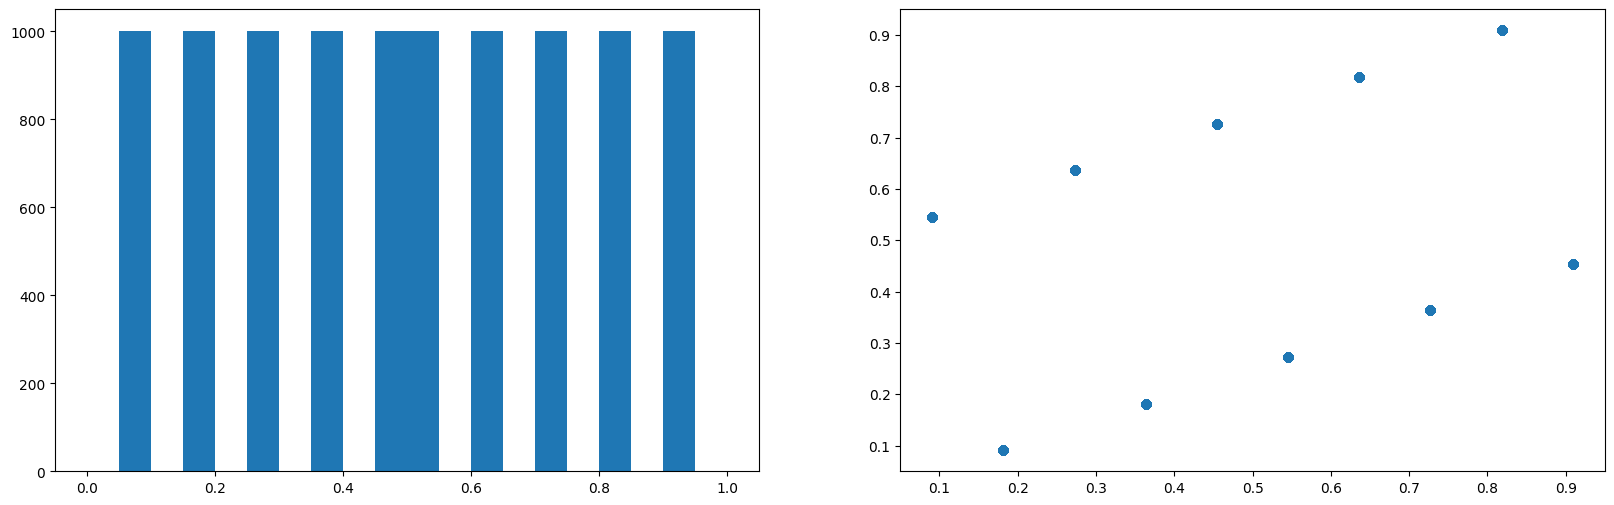

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.hist(test1, bins=20, range=(0, 1))
ax2.scatter(test1[:-1], test1[1:], alpha=0.5)

The histogram displays a few amount of bins, while the scatter plots display 10000 generated in a short loop - short cycle. Thus, it would suggest to violate randomness.

We print the different statistics:

In [56]:
num_bins = 10
observed_counts, _ = np.histogram(test1, bins=num_bins)
expected_count = len(test1) / num_bins
expected_counts = np.full(num_bins, expected_count)

T = sum((obs-exp)**2 / exp for obs, exp in zip(observed_counts, expected_counts))
df = 9
p_value = 1 - chi2.cdf(T, df)
print(f"Chi-square T = {T:.2f}, p-value = {p_value:.2f}")

sorted_test1 = np.sort(test1) #First sort
n = len(test1)

D_plus = np.max([(i + 1)/n - x for i, x in enumerate(sorted_test1)])
D_minus = np.max([x - i/n for i, x in enumerate(sorted_test1)])
D_statistic = max(D_plus, D_minus)

lambda_val = (sqrt(n) + 0.12 + 0.11/sqrt(n)) * D_statistic
p_value = 2 * sum((-1)**(k-1) * exp(-2 * k**2 * lambda_val**2) for k in range(1, 100))

print(f"KS statistic = {D_statistic:.2f}, p-value = {p_value:.2f}")

median = np.median(test1)
binary_seq = np.where(test1 > median, 1, 0)

runs = 1
for i in range(1, len(binary_seq)):
    if binary_seq[i] != binary_seq[i - 1]:
        runs += 1

n1 = np.sum(binary_seq)
n0 = len(binary_seq) - n1

mu = 2 * n1 * n0 / (n1 + n0) + 1
var = (2 * n1 * n0 * (2 * n1 * n0 - n1 - n0)) / (((n1 + n0) ** 2) * (n1 + n0 - 1))

z = (runs - mu) / sqrt(var)
p_value = 2 * (1 - norm.cdf(abs(z)))

print(f"Run test (Wald–Wolfowitz) score: z = {z:.2f}, p-value = {p_value:.2f}")
max_lag = 10
correlations = []
p_values = []

for lag in range(1, max_lag + 1):
    u1 = values[:-lag]
    u2 = values[lag:]
    corr, p_val = pearsonr(u1, u2)
    correlations.append(corr)
    p_values.append(p_val)
    print(f"Lag-{lag} correlation = {corr:.4f}, p-value = {p_val:.4f}")


Chi-square T = 0.00, p-value = 1.00
KS statistic = 0.09, p-value = 0.00
Run test (Wald–Wolfowitz) score: z = 20.00, p-value = 0.00
Lag-1 correlation = -0.0030, p-value = 0.7608
Lag-2 correlation = 0.0097, p-value = 0.3343
Lag-3 correlation = -0.0053, p-value = 0.5979
Lag-4 correlation = -0.0036, p-value = 0.7157
Lag-5 correlation = -0.0017, p-value = 0.8645
Lag-6 correlation = 0.0088, p-value = 0.3796
Lag-7 correlation = 0.0191, p-value = 0.0563
Lag-8 correlation = -0.0009, p-value = 0.9271
Lag-9 correlation = 0.0011, p-value = 0.9112
Lag-10 correlation = 0.0037, p-value = 0.7102


Although the $\chi^2$ test suggests perfect uniformity, the KS test and run test both strongly reject the hypothesis of randomness, revealing structural flaws in the generator. The lag correlation results show no significant linear dependence, but this alone is not enough to validate randomness given the other clear failures.

Moving on to the good case, where $a=16807$, $c=0$, $M=2^{31}-1$. Specifically, this configuration is known as the Park–Miller LCG:

In [57]:
test2 = linear_congruential(48271, 16807, 0, 2**31 - 1)  
test2

array([0.37778667, 0.46057146, 0.82450768, ..., 0.82405734, 0.93177724,
       0.38008405], shape=(10000,))

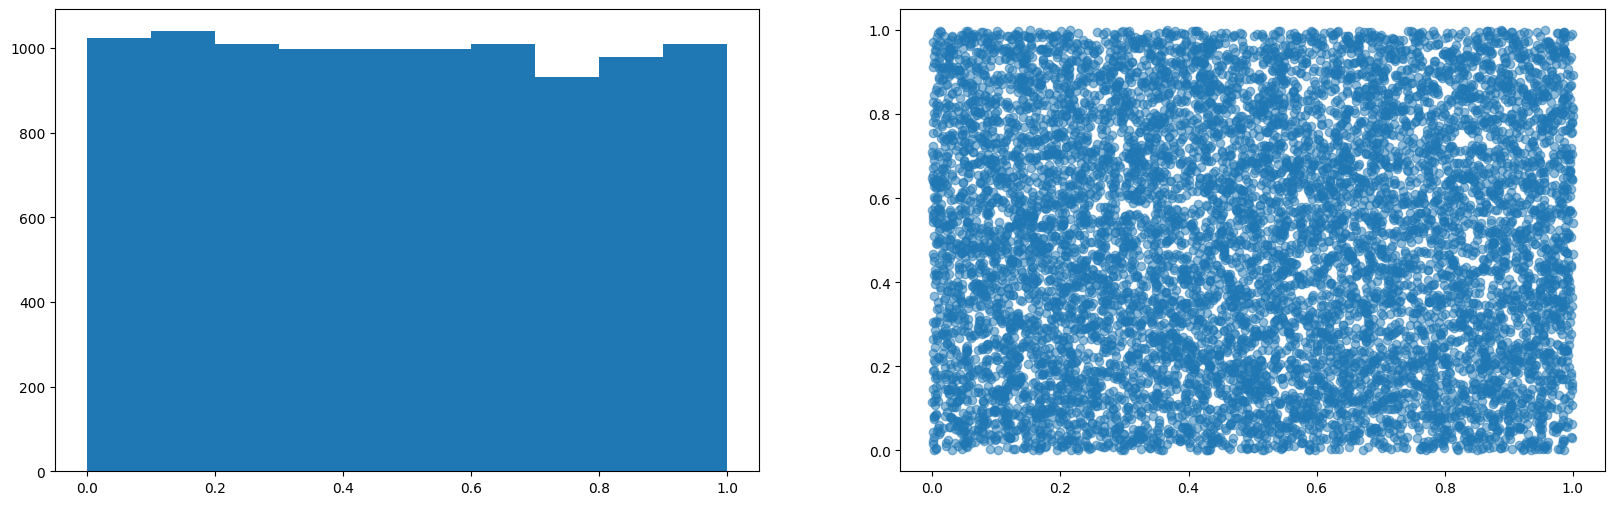

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.hist(test2)
ax2.scatter(test2[:-1], test2[1:], alpha=0.5)

Here, the histogram shows that the values are evenly distributed. Additionally, the scatter plot indicate no visible patterns, which is also to be expected as this configuration has a really long cycle of $M-1$.

Now for the tests:

In [59]:
num_bins = 10
observed_counts, _ = np.histogram(test2, bins=num_bins)
expected_count = len(test2) / num_bins
expected_counts = np.full(num_bins, expected_count)

T = sum((obs-exp)**2 / exp for obs, exp in zip(observed_counts, expected_counts))
df = 9
p_value = 1 - chi2.cdf(T, df)
print(f"Chi-square T = {T:.2f}, p-value = {p_value:.2f}")

sorted_test2 = np.sort(test2) #First sort
n = len(test2)

D_plus = np.max([(i + 1)/n - x for i, x in enumerate(sorted_test2)])
D_minus = np.max([x - i/n for i, x in enumerate(sorted_test2)])
D_statistic = max(D_plus, D_minus)

lambda_val = (sqrt(n) + 0.12 + 0.11/sqrt(n)) * D_statistic
p_value = 2 * sum((-1)**(k-1) * exp(-2 * k**2 * lambda_val**2) for k in range(1, 100))

print(f"KS statistic = {D_statistic:.2f}, p-value = {p_value:.2f}")

median = np.median(test2)
binary_seq = np.where(test2 > median, 1, 0)

runs = 1
for i in range(1, len(binary_seq)):
    if binary_seq[i] != binary_seq[i - 1]:
        runs += 1

n1 = np.sum(binary_seq)
n0 = len(binary_seq) - n1

mu = 2 * n1 * n0 / (n1 + n0) + 1
var = (2 * n1 * n0 * (2 * n1 * n0 - n1 - n0)) / (((n1 + n0) ** 2) * (n1 + n0 - 1))

z = (runs - mu) / sqrt(var)
p_value = 2 * (1 - norm.cdf(abs(z)))

print(f"Run test (Wald–Wolfowitz) score: z = {z:.2f}, p-value = {p_value:.2f}")
max_lag = 10
correlations = []
p_values = []

for lag in range(1, max_lag + 1):
    u1 = values[:-lag]
    u2 = values[lag:]
    corr, p_val = pearsonr(u1, u2)
    correlations.append(corr)
    p_values.append(p_val)
    print(f"Lag-{lag} correlation = {corr:.4f}, p-value = {p_val:.4f}")

Chi-square T = 7.40, p-value = 0.60
KS statistic = 0.01, p-value = 0.17
Run test (Wald–Wolfowitz) score: z = 0.08, p-value = 0.94
Lag-1 correlation = -0.0030, p-value = 0.7608
Lag-2 correlation = 0.0097, p-value = 0.3343
Lag-3 correlation = -0.0053, p-value = 0.5979
Lag-4 correlation = -0.0036, p-value = 0.7157
Lag-5 correlation = -0.0017, p-value = 0.8645
Lag-6 correlation = 0.0088, p-value = 0.3796
Lag-7 correlation = 0.0191, p-value = 0.0563
Lag-8 correlation = -0.0009, p-value = 0.9271
Lag-9 correlation = 0.0011, p-value = 0.9112
Lag-10 correlation = 0.0037, p-value = 0.7102


The $\chi^2$-test shows a high p-value, meaning the null hypothesis cannot be discarded of an uniform distribution. Thus, the generated numbers do suggest to follow an Uniform distribution.

Furthermore, the KS-statistic shows a somewhat high p-value. Once again, we cannot reject the null hypothesis, and there is no evidence against uniformity.

And due to the high p-value of Wald–Wolfowitz run test, we fail to discard the null hypothesis, meaning there is no statistical evidence to suggest the process is non-random. Thus, the number of runs is consistent with what we would expect from a random binary sequence, supporting the idea the generated values exhibit randomness relative to the median.

As for the lag correlations, they all show relatively correlations, meaning generated values are mostly independent (from the last 10 values). As for the p-values, they are all relatively high, but especially lag-7 has a p-value of 0.06, which is close to a value of $\alpha = 0.05$. Nonetheless, every lag has a high enough p-value, meaning we can reject the null hypotheseis - we do not have sufficient evidence of the values being dependent.

Overall, the generator suggests to produce random, independent values.

### 2. Apply a system available generator and perform the various statistical tests you did under Part 1 point (b) for this generator too.

Here, 10000 values are generated using NumPy’s built-in random number generator and evaluated for statistical quality. Specifically, 10.000 random values are generated, where $X\sim\text{Uniform}(0,1)$:

Chi-square T = 12.9860, p-value = 0.1632407713
KS statistic = 0.0075, p-value = 0.6178824245
Run test z   = -0.7200, p-value = 0.4715
Lag-1 correlation = 0.0042


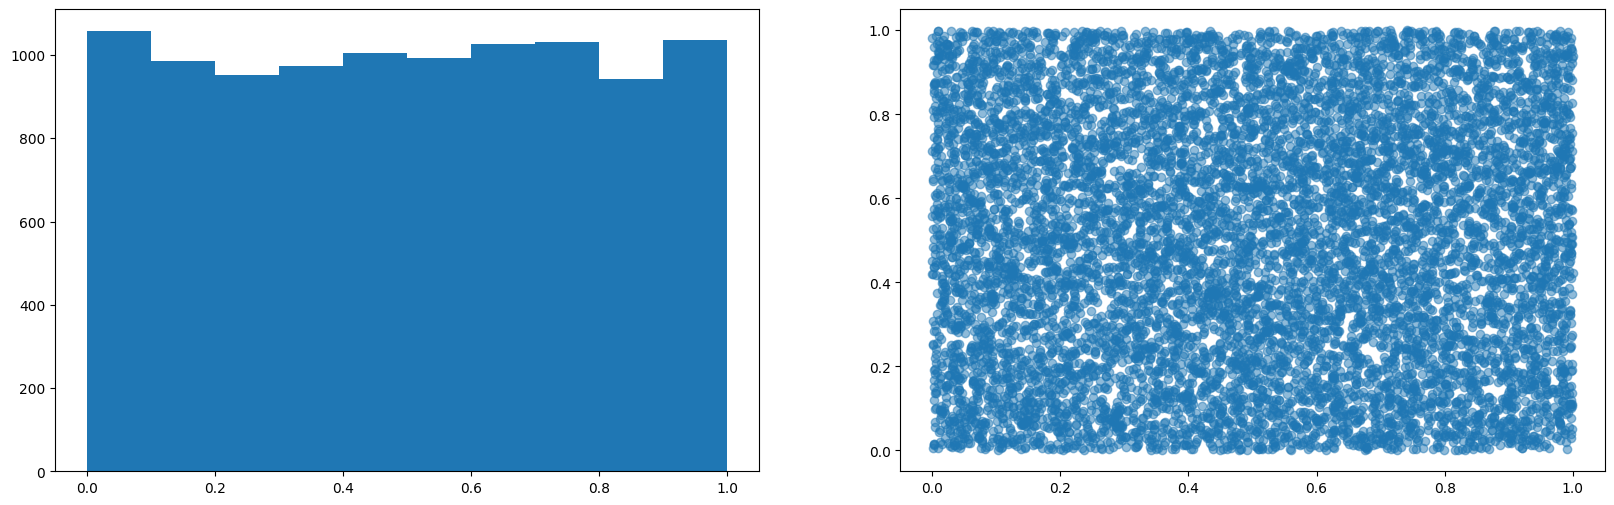

In [81]:
values = np.random.uniform(0, 1, 10000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.hist(values)
ax2.scatter(values[:-1], values[1:], alpha=0.5)

num_bins = 10
observed_counts, _ = np.histogram(values, bins=num_bins)
expected_counts = np.full(num_bins, len(values) / num_bins)
T = sum((obs - exp)**2 / exp for obs, exp in zip(observed_counts, expected_counts))
chi2_stat, p_val_chi2 = chisquare(f_obs=observed_counts, f_exp=expected_counts)
ks_stat, p_val_ks = kstest(values, 'uniform')
median = np.median(values)
binary_seq = np.where(values > median, 1, 0)
z_stat, p_val_run = runstest_1samp(binary_seq)
u1 = values[:-1]
u2 = values[1:]
correlation = np.corrcoef(u1, u2)[0, 1]

print(f"Chi-square T = {T:.4f}, p-value = {p_val_chi2:.10f}")
print(f"KS statistic = {ks_stat:.4f}, p-value = {p_val_ks:.10f}")
print(f"Run test z   = {z_stat:.4f}, p-value = {p_val_run:.4f}")
print(f"Lag-1 correlation = {correlation:.4f}")

The histogram shows an even distribution, indicating good uniformity, while the scatter plot reveals no visible patterns, suggesting independence.

The Chi-square shows a p-value of approximately 0.16, indicating no significant deviation from the expected uniform distribution. Similarly, KS test yields a high p-value of 0.61, further supporting the hypothesis that the values are uniformly distributed over the interval [0,1].

The run test shows a p-value of 0.47, suggesting that the sequence does exhibit randomness.

The lag-1 correlation is very close to 0, confirming the lack of correlation between successive values and indicating strong independence.

Despite minor fluctuations expected in limited samples ($n=10000$), the overall results show excellent statistical behavior from the system's built-in random number generator. It passes all basic tests of uniformity, independence, and randomness.

It is therefore considered suitable for use in simulation and statistical applications.

### 3. You were asked to simulate one sample and perform tests on this sample. Discuss the sufficiency of this approach and take action, if needed.

I think testing just one sample can give a general idea of how good the generator is, but it’s probably not enough on its own. Since random variation can affect the outcome, a single test might not reflect the generator’s actual behavior. To be more confident, I tried generating and testing multiple samples. The results were consistent across runs which made me feel more sure that the generator is performing reliably and that the earlier results were not just "random" strokes of luck.

If $H_0$ is true — meaning the generator produces truly uniform and independent values — then the p values obtained from repeated valid tests should themselves be uniformly distributed on the interval $[0,1)$. This means we should roughly expect an even spread of p-values across multiple runs, with no systematic clustering or patterns near 0 or 1. Observing such a uniform distribution would support the correctness of both the generator and the statistical tests used.